In [1]:
import numpy as np
import typing as ty
import matplotlib.pylab as plt
from lava.magma.core.learning.constants import GradedSpikeCfg

from lava.utils.weightutils import SignMode

from lava.magma.core.learning.learning_rule import Loihi3FLearningRule

from lava.magma.core.run_configs import Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps
from lava.proc.clp.prototype_lif.process import PrototypeLIF
from lava.proc.clp.novelty_detector.process import NoveltyDetector
from lava.proc.clp.nsm.process import Readout, Allocator
from lava.proc.io.source import RingBuffer, PySendModelFixed
from lava.proc.monitor.process import Monitor
from lava.proc.dense.process import Dense, LearningDense
from lava.proc.dense.models import PyLearningDenseModelBitApproximate

In [2]:
# Load COIL-100 data (selected, well-separated 42 objects)
with open('coil100_features_separated_objs.npy', 'rb') as f:
    X = np.load(f)
    y = np.load(f)

y = y + 1  # the label==0 is reserved for no information on communication channel
# Normalize the vectors
X = X / np.expand_dims(np.linalg.norm(X, axis=1), axis=1)
print(X.shape, y.shape)

(3024, 2048) (3024,)


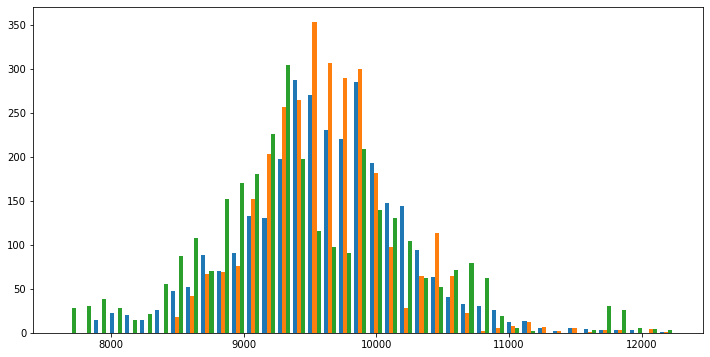

In [3]:
b_fraction = 7  # The fraction of the fixed point representation used to translate floating point input to graded spikes
X_fixed = np.floor(X * 2 ** b_fraction).astype(np.int32)
sim_single = np.dot(X_fixed[np.random.randint(low=0, high=42*72, size=3),:], X_fixed.T)
plt.figure(figsize=(12,6))
plt.hist(sim_single.T, bins=40)
plt.show()

#### Train-test split
There are 72 frames for each object. Let's go ahead and decide how many samples per class we want to provide for training. 

In [4]:
from sklearn.model_selection import train_test_split
n_train_per_class = 3
X_train, X_test, y_train, y_test = train_test_split(X_fixed, y, test_size=(72-n_train_per_class)/72, random_state=42, stratify=y)

#### Ordering of the data
Next, we will order the training and testing samples by the objects. This way we simulate online sequential learning. Note that this data order is non-i.i.d, as there is no shuffling.  

In [5]:
X_train = X_train[np.argsort(y_train),:]
y_train = y_train[np.argsort(y_train)]

#### Sub-sampling the data
If we wish, we can subsample the test set of each object class by the factor ```k_sample```, as the consecutive image frames are very similar.

In [6]:
k_sample = 3
X_test = X_test[np.argsort(y_test),:][::k_sample, :]
y_test = y_test[np.argsort(y_test)][::k_sample]


Additionally, we can choose how many objects we want to learn out of 42 objects available in the subset of the original dataset that we are providing here in terms of extracted feature vectors. 

In [7]:
n_classes = 20

X_train = X_train[y_train<=n_classes, :]
X_test = X_test[y_test<=n_classes, :]
y_train = y_train[y_train<=n_classes]
y_test = y_test[y_test<=n_classes]

print(X_train.shape)
print(X_test.shape)

(60, 2048)
(460, 2048)


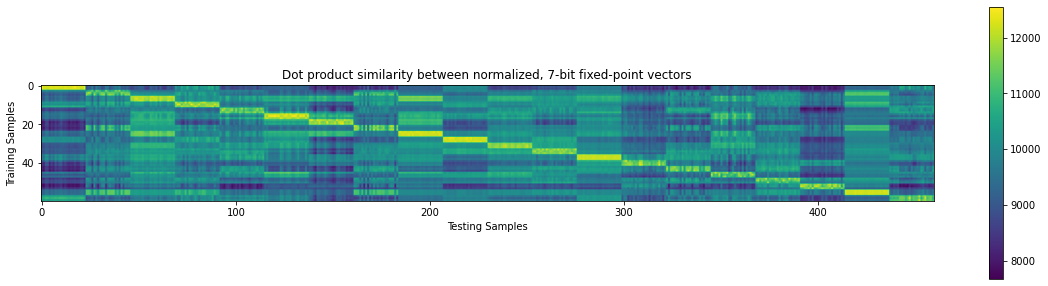

In [8]:
sims = np.dot(X_train, X_test.T)
plt.figure(figsize=(20,5))
plt.imshow(sims)
plt.colorbar()
plt.title("Dot product similarity between normalized, 7-bit fixed-point vectors")
plt.xlabel("Testing Samples")
plt.ylabel("Training Samples")
plt.show()

### Temporal WTA 

#### (Optional) Hyperparameter search for PrototypeLIF

In [9]:
# from utils import wta_hyperparam_search
# a_in = np.array([10500, 11000, 11300, 11600, 11900, 12200])
# n_steps = 35
# best_params = wta_hyperparam_search(a_in, n_steps)

### Visualize voltage dynamics
Let's also visualize the voltage dynamics with the chosen hyperparameters for the input values we wanted to distinguish in the temporal domain
<center><img src="../../in_depth/clp/images/wta_voltage.png" style="width:50%"><center>
<center><figcaption align = "center"> Figure 1. Voltage dynamics for different values of input current </figcaption><center>

### Setup the CLP network

### Parameterization of CLP

In [10]:
# General params
n_features = X_train.shape[1]
t_wait = 14  # the waiting window for novelty detection after input injection
n_protos = 80  # number of the prototypes
# The time difference between two consecutive inputs
n_steps_per_sample = 35

# PrototypeLIF neural dynamics parameters
du = 50
dv = 700
vth = 52000



In [11]:
from clp import CLP

clp = CLP(supervised=True,
          n_protos,
          n_features,
          n_steps_per_sample,
          b_fraction,
          du,
          dv,
          vth,
          t_wait)

s_pattern_inp, s_user_label = clp.generate_input_spikes(X_train, X_test, y_train)
clp = clp.setup_procs_and_conns(s_pattern_inp, s_user_label)

prototypes = clp.prototypes

In [12]:
# Run
exception_map = {
        LearningDense: PyLearningDenseModelBitApproximate
}
run_cond = RunSteps(num_steps=clp.num_steps)
run_cfg = Loihi2SimCfg(select_tag="fixed_pt",
                       exception_proc_model_map=exception_map)

prototypes.run(condition=run_cond, run_cfg=run_cfg)

novelty_spikes, proto_spikes, error_spikes, preds = clp.get_results()

# voltages = monitor_v.get_data()[prototypes.name][
#     prototypes.v.name]

# currents = monitor_u.get_data()[prototypes.name][
#     prototypes.u.name]

# result_weights = monitor_weights.get_data()
# result_weights = result_weights[dense_proto.name][
#     dense_proto.weights.name]

# Stop the run
prototypes.stop()


In [13]:
from utils import  plot_spikes, plot_spikes_time_series
time = np.arange(num_steps)
plot_spikes_time_series(
        spikes=[np.where(proto_spikes[:, 9])[0],
                np.where(proto_spikes[:, 8])[0],
                np.where(proto_spikes[:, 7])[0],
                np.where(proto_spikes[:, 6])[0],
                np.where(proto_spikes[:, 5])[0],
                np.where(proto_spikes[:, 4])[0],
                np.where(proto_spikes[:, 3])[0],
                np.where(proto_spikes[:, 2])[0],
                np.where(proto_spikes[:, 1])[0],
                np.where(proto_spikes[:, 0])[0],
                np.where(error_spikes)[0],
                np.where(novelty_spikes)[0],
                np.where(s_pattern_inp[0, :])[0]],
        time_series=preds,
        time=time,
        figsize=(20, 8),
        legend=['Prototype Neuron 9', 'Prototype Neuron 8',
                'Prototype Neuron 7', 'Prototype Neuron 6',
                'Prototype Neuron 5', 'Prototype Neuron 4',
                'Prototype Neuron 3', 'Prototype Neuron 2',
                'Prototype Neuron 1', 'Prototype Neuron 0', 
                'Error Spikes', 'Novelty Spikes', 'Input Injection'],
        colors=['blue', '#458b00', '#f14a16', '#458b00', '#ff9912', '#458b00', 'purple', '#f14a16', 'blue', '#ff9912','r','#458b00', '#f14a16', '#458b00'],
        title='Spike Raster Plot',
        num_steps=num_steps
)

NameError: name 'num_steps' is not defined

In [15]:
n_train_samples = X_train.shape[1]

In [16]:
y_pred = np.maximum.reduceat(preds.copy(),np.r_[0:len(preds):n_steps_per_sample])[n_train_samples:]

In [18]:
y_pred 

array([], shape=(0, 1), dtype=float64)

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, y_pred)
print(acc)

ValueError: Found input variables with inconsistent numbers of samples: [460, 0]

In [233]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)

0.9760869565217392
